# ML-Rank Histograms in Basin

For the initial conditions

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *

### Perturbing initial conditions

In [6]:
sample_args = {
    "g": 9.81,
    "f": 0.0012,
    }

In [7]:
ls = [8, 9]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
init_model_error_basis_args = {
    "basis_x_start": 1, 
    "basis_x_end": 6,
    "basis_y_start": 2,
    "basis_y_end": 7,

    "kl_decay": 1.25,
    "kl_scaling": 0.18,
}

In [10]:
ML_Nes =[150, 50]

### Ensemble

In [11]:
data_args_list = []

for l_idx in range(len(ML_Nes)):
    data_args_list.append( make_init_steady_state(args_list[l_idx]) )


In [12]:
# Model errors
init_mekls = []
for l_idx in range(len(args_list)): 
    init_mekls.append( ModelErrorKL.ModelErrorKL(**args_list[l_idx], **init_model_error_basis_args) )

## MultiLevel ensemble
# only used to initialise classes
ML_ensemble = []

# 0-level
lvl_ensemble = []
for i in range(ML_Nes[0]):
    if i % 100 == 0: print(i)
    sim = make_sim(args_list[0], sample_args, init_fields=data_args_list[0])
    init_mekls[0].perturbSim(sim)

    lvl_ensemble.append( sim )

ML_ensemble.append(lvl_ensemble)

# diff-levels
for l_idx in range(1,len(ML_Nes)):
    print(l_idx)
    lvl_ensemble0 = []
    lvl_ensemble1 = []
    
    for e in range(ML_Nes[l_idx]):
        sim0 = make_sim(args_list[l_idx], sample_args, init_fields=data_args_list[l_idx])
        sim1 = make_sim(args_list[l_idx-1], sample_args, init_fields=data_args_list[l_idx-1])
        
        init_mekls[l_idx].perturbSim(sim0)
        init_mekls[l_idx-1].perturbSimSimilarAs(sim1, modelError=init_mekls[l_idx])

        lvl_ensemble0.append(sim0)
        lvl_ensemble1.append(sim1)
    
    ML_ensemble.append([lvl_ensemble0,lvl_ensemble1])

0
100
1


In [13]:
from gpuocean.ensembles import MultiLevelOceanEnsemble
MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsemble(ML_ensemble)

### Rank histograms

In [14]:
freq = 50
rankHxs = np.arange(0, args_list[-1]["nx"], freq)
rankHys = np.arange(0, args_list[-1]["ny"], 2*freq)

In [15]:
N_ranks = 250

In [16]:
ML_ranks = np.zeros((len(rankHxs)*N_ranks,3))

In [17]:
truth_scaling = [0.09, 0.18, 0.36]

In [18]:
ML_ranks_scaling = [copy.deepcopy(ML_ranks) for s in range(len(truth_scaling))]

for s in range(len(truth_scaling)):

    truth = make_sim(args_list[-1], sample_args=sample_args, init_fields=data_args_list[-1])
    truth_init_model_error_basis_args = copy.deepcopy(init_model_error_basis_args)
    truth_init_model_error_basis_args["kl_scaling"] = truth_scaling[s]
    init_mekl = ModelErrorKL.ModelErrorKL(**args_list[-1], **truth_init_model_error_basis_args)
    init_mekl.perturbSim(truth)

    for n in range(N_ranks):
        print(n)
        ## New Ensemble
        # 0-level
        for e in range(ML_Nes[0]):
            MLOceanEnsemble.ML_ensemble[0][e].upload(data_args_list[0]["eta"], data_args_list[0]["hu"], data_args_list[0]["hv"])
            MLOceanEnsemble.ML_ensemble[0][e].t = 0.0
            init_mekls[0].perturbSim(MLOceanEnsemble.ML_ensemble[0][e])

        # diff-levels
        for l_idx in range(1,len(ML_Nes)):
            for e in range(ML_Nes[l_idx]):
                MLOceanEnsemble.ML_ensemble[l_idx][0][e].upload(data_args_list[l_idx]["eta"], data_args_list[l_idx]["hu"], data_args_list[l_idx]["hv"])
                MLOceanEnsemble.ML_ensemble[l_idx][0][e].t = 0.0
                
                MLOceanEnsemble.ML_ensemble[l_idx][1][e].upload(data_args_list[l_idx-1]["eta"], data_args_list[l_idx-1]["hu"], data_args_list[l_idx-1]["hv"])
                MLOceanEnsemble.ML_ensemble[l_idx][1][e].t = 0.0

                init_mekls[l_idx].perturbSim(MLOceanEnsemble.ML_ensemble[l_idx][0][e])
                init_mekls[l_idx-1].perturbSimSimilarAs(MLOceanEnsemble.ML_ensemble[l_idx][1][e], modelError=init_mekls[l_idx])

        ## New Truth
        truth.upload(data_args_list[-1]["eta"], data_args_list[-1]["hu"], data_args_list[-1]["hv"])
        truth.t = 0.0
        init_mekl.perturbSim(truth)

        ## Ranks
        ML_ranks_scaling[s][n*len(rankHxs):(n+1)*len(rankHxs)] = MLOceanEnsemble.rank(truth, [z for z in zip(rankHxs, rankHys)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [19]:
def plot_histogram(ML_ranks, bins_size=1/25):
    
    fig, axs = plt.subplots(1, 3, figsize=(15,3))
    fig.suptitle(r"$\bf{ML ranks}$",y=1.1)

    axs[0].set_title("eta")
    axs[1].set_title("hu")
    axs[2].set_title("hv")

    bins = np.arange(0,1+1e-9,bins_size)

    for i in range(3):
        hist = np.histogram(ML_ranks[:,i], bins=bins)
        axs[i].bar(0.5*(hist[1][1:]+hist[1][:-1]),hist[0]/len(ML_ranks)/bins_size, width=bins_size, color="C0")
        
        axs[i].set_ylim((0,1.5))
        axs[i].set_xlim((0,1.0))

        axs[i].plot([0,1],[1,1], color="black", ls="--", lw=3)

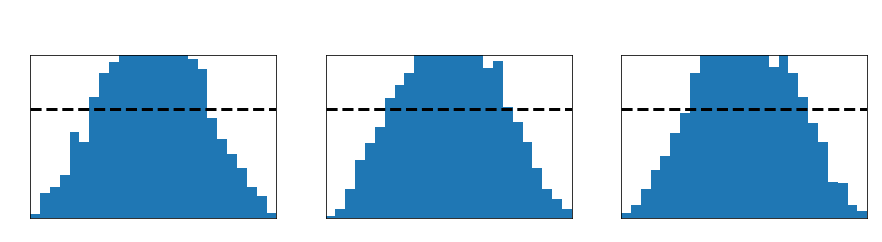

In [22]:
plot_histogram(ML_ranks_scaling[0])

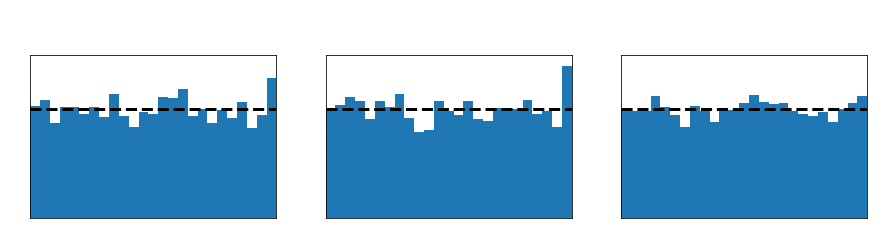

In [23]:
plot_histogram(ML_ranks_scaling[1])

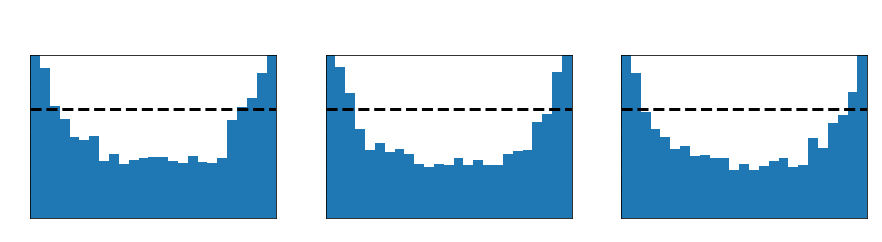

In [24]:
plot_histogram(ML_ranks_scaling[2])